In [5]:
import numpy as np
import neurokit2 as nk
from scipy import integrate
import pickle
import pandas as pd
import numpy as np

# acceleration
def acc(speed, time):
    return np.gradient(speed, time, edge_order=2)

# motion sickness dose value
def msdv_eq(speed, time):
    return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))

# peaks
def find_peaks(gsr):
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    return sum(num_of_peaks)

# load data
data_path = './data/raw_data2020.p'
dataPoolfont_sizefont_size = pickle.load(open(data_path, "rb"))

num_of_samples = len(list(dataPoolfont_sizefont_size.keys()))
# num_of_samples = 1
num_of_interval = 30

figsize = (15, 10)

input_list = []
output_list = []

for j in range(num_of_samples):
    name = list(dataPoolfont_sizefont_size.keys())[j]
    one_sample = dataPoolfont_sizefont_size[name]
    time_speed = one_sample.Steam.rawSpeed.Time
    raw_speed = one_sample.Steam.rawSpeed.Speed
    GSR = one_sample.Empatica.GSR
    time_eda = one_sample.Empatica.GSR.Time
    one_sample_input = []
    one_sample_output = []
    
    # adjust time scale
    t = np.arange(0, 0.25*len(GSR), 0.25)
    t_difference = t[-1] - time_speed.iloc[-1]
    if t_difference >= 0:
        countTimeInZero = int(t_difference/0.25)
        timeBase = t[countTimeInZero]
        t -= timeBase
    GSR.E4_Time = t
    GSR = GSR.drop(GSR[GSR.E4_Time < 0].index)
    GSR.reset_index(drop=True, inplace=True)
    
    # Peaks
    # method = neurokit / biosppy
    decomposed_eda = nk.eda_process(GSR.GSR, sampling_rate=4)[0]
    step = int(len(GSR.GSR) / num_of_interval)
    peaks_list = []
    piece_gsr = []
    for i in range(0, len(GSR.GSR), step):
        if len(GSR.GSR[i: i+step]) < step:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i-step:], 
                                                  sampling_rate=4)
            peaks_list[-1] = eda_interval["SCR_Peaks_N"].values
            piece_gsr[-1] = decomposed_eda["EDA_Raw"][i-step:].values
            # piece_gsr[-1] = decomposed_eda["EDA_Phasic"][i-step:].values
        else:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i: i+step], 
                                                  sampling_rate=4)
            peaks_list.append(eda_interval["SCR_Peaks_N"].values)
            piece_gsr.append(decomposed_eda["EDA_Raw"][i: i+step].values)
            # piece_gsr.append(decomposed_eda["EDA_Phasic"][i: i+step].values)

    # MSDV
    msdv_list = []
    step = int(len(time_speed) / num_of_interval)
    speed_list = []
    for i in range(0, len(raw_speed), step):
        if len(raw_speed[i: i+step]) < step:
            speed_list[-1] = raw_speed[i-step:].values
            msdv_list[-1] = msdv_eq(raw_speed[i-step:], time_speed[i-step:])
        else:
            speed_list.append(raw_speed[i: i+step].values)
            msdv_list.append(msdv_eq(raw_speed[i: i+step], time_speed[i: i+step]))
    
    input_list.append([name, speed_list, piece_gsr]) # INPUT
    output_list.append([name, msdv_list, peaks_list]) # OUTPUT

merged_input_list = []
merged_output_list = []
for i in range(num_of_samples):
    # remove group name
    input_list[i][0] = input_list[i][0].split("group")[0]
    input_list[i][0] = input_list[i][0].split("gift")[0]
    output_list[i][0] = output_list[i][0].split("group")[0]
    output_list[i][0] = output_list[i][0].split("gift")[0]
# merge info
skip_step, pivot = 0, 0
for i in range(num_of_samples):
    name = input_list[pivot][0]
    tmp_speed = input_list[pivot][1]
    tmp_gsr = input_list[pivot][2]
    tmp_msdv = output_list[pivot][1]
    tmp_peaks = output_list[pivot][2]
    matched = False
    for j in range(pivot+1, num_of_samples, 1):
        if name == input_list[j][0]:
            tmp_speed = tmp_speed + input_list[j][1]
            tmp_gsr = tmp_gsr + input_list[j][2]
            tmp_msdv = tmp_msdv + output_list[j][1]
            tmp_peaks = tmp_peaks + output_list[j][2]
            skip_step = j
            matched = True
    merged_input_list.append([name, tmp_speed, tmp_gsr])
    merged_output_list.append([name, tmp_msdv, tmp_peaks])
    if matched:
        pivot = skip_step+1
    else:
        pivot += 1
    if pivot >= num_of_samples:
        break

# file_name = './peaks/data0_BingHan4.txt'
# with open(file_name, 'wb') as fp:
#     pickle.dump(merged_output_list[4][2], fp)

file_name = 'input.txt'
with open(file_name, 'wb') as fp:
    pickle.dump(merged_input_list, fp)


/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_61472/3559685774.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_61472/3559685774.py:14: De

In [94]:
# 初始化一个空列表来存储所有的 average 值
all_averages = []

# 记录所有的 average 值
for index in range(53):  # 包括 0 到 52
    length = len(merged_input_list[index][1])
    for i in range(length):
        # 计算每个样本的 average 值
        average = np.mean(merged_input_list[index][2][i])
        all_averages.append(average)

# 将所有的 average 值转为 numpy 数组
all_averages = np.array(all_averages)

# 计算10%、20%、...、90%的分位点
percentiles = [5, 20, 30, 40, 50, 60, 70, 80, 90]
boundaries = np.percentile(all_averages, percentiles)

print("Boundary values (percentiles):", boundaries)

Boundary values (percentiles): [0.06593224 0.22635852 0.49723496 1.52497042 2.44425655 3.57594897
 4.75210448 6.36503633 9.66126052]


In [97]:
# 使用这些 boundary 值来设置 sickness_level
for index in range(53):  # 包括 0 到 52
    action, msdv, sickness_level = [], [], []
    
    length = len(merged_input_list[index][1])
    for i in range(length):
        # 计算 average
        average = np.mean(merged_input_list[index][2][i])
        
        # 根据 boundary 设置 sickness_level
        if average <= boundaries[0]:
            sickness_level.append(0.1)
        elif boundaries[0] < average <= boundaries[1]:
            sickness_level.append(0.2)
        elif boundaries[1] < average <= boundaries[2]:
            sickness_level.append(0.3)
        elif boundaries[2] < average <= boundaries[3]:
            sickness_level.append(0.4)
        elif boundaries[3] < average <= boundaries[4]:
            sickness_level.append(0.5)
        elif boundaries[4] < average <= boundaries[5]:
            sickness_level.append(0.6)
        elif boundaries[5] < average <= boundaries[6]:
            sickness_level.append(0.7)
        elif boundaries[6] < average <= boundaries[7]:
            sickness_level.append(0.8)
        else:
            sickness_level.append(0.9)

In [98]:
import numpy as np
import scipy.io

# 初始化存储所有index的数据列表
all_actions = []
all_msdv = []
all_sickness_levels = []

# 定义边界条件 王老师的分法
# bound = [1, 0.8, 0.1, 2.5, 4]
# 我suggest一个新的分类方法 提升类别的数量，然后一定程度帮助到图像的可视化 （定义从 0 到 4 均匀分成 9 份的边界）

bound = np.linspace(0, 4, 10)  # 包含 10 个边界点（包括 0 和 4）




# 遍历每个index
for index in range(53):  # 包括 0 到 52
    action, msdv, sickness_level = [], [], []
    
    length = len(merged_input_list[index][1])
    for i in range(length):
        # speed <=> action
        if np.mean(merged_input_list[index][1][i]) < bound[0]:
            action.append(0)
        else:
            action.append(1)
        
        # msdv <=> reward 
        if np.mean(merged_output_list[index][1][i]) < bound[1]:
            msdv.append(0)
        else:
            msdv.append(1)
        
        # true sickness level
        average = np.mean(merged_input_list[index][2][i])
        
        # 根据 boundary 设置 sickness_level
        if average <= boundaries[0]:
            sickness_level.append(0.1)
        elif boundaries[0] < average <= boundaries[1]:
            sickness_level.append(0.2)
        elif boundaries[1] < average <= boundaries[2]:
            sickness_level.append(0.3)
        elif boundaries[2] < average <= boundaries[3]:
            sickness_level.append(0.4)
        elif boundaries[3] < average <= boundaries[4]:
            sickness_level.append(0.5)
        elif boundaries[4] < average <= boundaries[5]:
            sickness_level.append(0.6)
        elif boundaries[5] < average <= boundaries[6]:
            sickness_level.append(0.7)
        elif boundaries[6] < average <= boundaries[7]:
            sickness_level.append(0.8)
        else:
            sickness_level.append(0.9)

    action = np.double(action)
    msdv = np.double(msdv)
    
    # 将当前 index 的数据添加到总列表中
    all_actions.append(action)
    all_msdv.append(msdv)
    all_sickness_levels.append(sickness_level)

# 将所有 index 的数据打包为字典
Data_0 = {'action': all_actions, 'reward': all_msdv}
Data = {"level": all_sickness_levels}

# 保存为 .mat 文件（如果需要）
scipy.io.savemat('Data.mat', Data_0, oned_as='column')
scipy.io.savemat("Sickness_level.mat", Data, oned_as='row')


In [99]:
# # 120 trails: 'BingHan'4, 'Cunbo'7, 'Guanzhi'12, 'Lingfeng'26, 'Minghui'31, 'Olaf'32,
# #                'Qichen'34, 'Wenzhe'40, 'Xinrui'43, 'Zhilong'51, 'Zihan'52
# index = 52
# action, msdv, sickness_level = [], [], []
# # bound = [speed, msdv, sickness_level(1), sickness_level(2), sickness_level(3)]
# bound = [1, 0.8, 0.1, 2.5, 4]
# for i in range(120):
#     # speed <=> action
#     if np.mean(merged_input_list[index][1][i]) < bound[0]:
#         action.append(0)
#     else:
#         action.append(1)
#     # msdv <=> reward 
#     if np.mean(merged_output_list[index][1][i]) < bound[1]:
#         msdv.append(0)
#     else:
#         msdv.append(1)
#     # true sickness level
#     average = np.mean(merged_input_list[index][2][i])
#     if average <= bound[2]:
#         sickness_level.append(0.1)
#     elif bound[2] < average <= bound[3]:
#         sickness_level.append(0.4)
#     elif bound[3] < average <= bound[4]:
#         sickness_level.append(0.6)
#     else:
#         sickness_level.append(0.9)
    
# action = np.double(action)
# msdv = np.double(msdv)
# # save as .mat file
# import scipy
# Data_0 = {'action': action, 'reward': msdv}
# scipy.io.savemat('Data.mat', Data_0, oned_as='column')
# Data = {"level": sickness_level}
# scipy.io.savemat("Sickness_level.mat", Data, oned_as='row')

In [100]:
df_output = pd.DataFrame(merged_output_list,columns=['tester', 'msdv', 'peaks'])
df_output

,tester,msdv,peaks
0,Andreas,"[[0.0, 10.235038632014964, 14.073332389627016,...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2...."
1,Anjela,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1...."
2,Anne,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [7.0], [5.0], [4.0], [6.0], [4.0], [6...."
3,Aron,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [4.0], [5.0], [3.0], [5.0], [6.0], [3...."
4,BingHan,"[[0.0, 3.154252773752122, 3.7037348249875524, ...","[[2.0], [2.0], [1.0], [0.0], [2.0], [1.0], [1...."
5,Bowen,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0], [5.0], [4.0], [4.0], [4.0], [6.0], [5...."
6,Chenyang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,Cunbo,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [5.0], [5.0], [5.0], [6.0], [5.0], [6...."
8,Danfo,"[[0.0, 6.530872954118741, 7.6432728994553365, ...","[[0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0...."
9,Emilio,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.0], [4.0], [7.0], [6.0], [7.0], [6.0], [6...."


In [101]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input

# 初始化存储合并后数据的列表
all_padded_msdv_inputs = []
all_reward_outputs = []
all_aux_inputs = []

# 固定最大时间步长
max_time_step = 748  # 目标时间步长，假设你提到的最大可能长度为 748

# 循环处理每个 index，并将每个样本中的序列 padding 到相同的时间步长
for index in range(53):  # 包括 0 到 52
    # 加载数据
    msdv_input = df_output['msdv'][index]  # 90xX 的数据
    reward_output = Data['level'][index]  # 从 Data['level'] 中提取与 msdv_input 对应的数量
    aux_input_data = Data_0['reward'][index]  # 从 Data_0['action'] 中提取与 msdv_input 对应的数量

    # 对每个 msdv_input 中的序列进行 padding，使其时间步长一致到 max_time_step
    padded_msdv_input = pad_sequences(msdv_input, maxlen=max_time_step, padding='post', dtype='float32')

    # 将 reward_output 和 aux_input_data 转换为 numpy 数组并扩展为二维
    reward_output = np.array(reward_output).reshape(-1, 1)
    aux_input_data = np.array(aux_input_data).reshape(-1, 1)

    # 调整输入形状，使其具有 3 个维度： (batch_size, sequence_length, features)
    padded_msdv_input = np.expand_dims(padded_msdv_input, axis=-1)  # 添加一个特征维度

    # 将处理后的数据添加到总列表中
    all_padded_msdv_inputs.append(padded_msdv_input)
    all_reward_outputs.append(reward_output)
    all_aux_inputs.append(aux_input_data)

# 合并所有人的数据
all_padded_msdv_inputs = np.concatenate(all_padded_msdv_inputs, axis=0)
all_reward_outputs = np.concatenate(all_reward_outputs, axis=0)
all_aux_inputs = np.concatenate(all_aux_inputs, axis=0)

# 检查合并后数据的形状
print(f"All padded_msdv_inputs shape: {all_padded_msdv_inputs.shape}")
print(f"All reward_outputs shape: {all_reward_outputs.shape}")
print(f"All aux_inputs shape: {all_aux_inputs.shape}")

# 获取时间步长和输入形状
X = all_padded_msdv_inputs.shape[1]  # 获取时间步长

# 输入形状
input_shape = all_padded_msdv_inputs.shape[1:]  # (max_time_step, 1)

# 主要输入
main_input = Input(shape=input_shape, name="main_input")

# 辅助输入
aux_input = Input(shape=(1,), name="aux_input")


All padded_msdv_inputs shape: (4680, 748, 1)
All reward_outputs shape: (4680, 1)
All aux_inputs shape: (4680, 1)


In [91]:
# import numpy as np

# # 对每一个 dt 进行归一化
# for i, dt in enumerate(all_padded_msdv_inputs):
#     print(f"Before normalization - dt[{i}] shape: {dt.shape}, max value: {np.max(dt)}, min value: {np.min(dt)}")
    
#     # 对每个 dt 进行归一化
#     dt_min = np.min(dt)
#     dt_max = np.max(dt)
    
#     # 处理可能的零除问题
#     if dt_max - dt_min > 0:
#         all_padded_msdv_inputs[i] = (dt - dt_min) / (dt_max - dt_min)
#     else:
#         all_padded_msdv_inputs[i] = np.zeros_like(dt)

In [102]:
import numpy as np

# 对每一个 dt 进行归一化
for i, dt in enumerate(all_padded_msdv_inputs):
    print(f"Before normalization - dt[{i}] shape: {dt.shape}, max value: {np.max(dt)}, min value: {np.min(dt)}")
    
    # 对每个 dt 进行归一化
    dt_min = np.min(dt)
    dt_max = np.max(dt)
    
    # 处理可能的零除问题
    if dt_max - dt_min > 0:
        all_padded_msdv_inputs[i] = (dt - dt_min) / (dt_max - dt_min)
    else:
        all_padded_msdv_inputs[i] = np.zeros_like(dt)
    
    print(f"After normalization - dt[{i}] shape: {all_padded_msdv_inputs[i].shape}, max value: {np.max(all_padded_msdv_inputs[i])}, min value: {np.min(all_padded_msdv_inputs[i])}")


Before normalization - dt[0] shape: (748, 1), max value: 15.94375991821289, min value: 0.0
After normalization - dt[0] shape: (748, 1), max value: 1.0, min value: 0.0
Before normalization - dt[1] shape: (748, 1), max value: 1.1019315719604492, min value: 0.0
After normalization - dt[1] shape: (748, 1), max value: 1.0, min value: 0.0
Before normalization - dt[2] shape: (748, 1), max value: 15.244211196899414, min value: 0.0
After normalization - dt[2] shape: (748, 1), max value: 1.0, min value: 0.0
Before normalization - dt[3] shape: (748, 1), max value: 0.8374702334403992, min value: 0.0
After normalization - dt[3] shape: (748, 1), max value: 1.0, min value: 0.0
Before normalization - dt[4] shape: (748, 1), max value: 0.5177537202835083, min value: 0.0
After normalization - dt[4] shape: (748, 1), max value: 1.0, min value: 0.0
Before normalization - dt[5] shape: (748, 1), max value: 0.36879292130470276, min value: 0.0
After normalization - dt[5] shape: (748, 1), max value: 1.0, min val

In [103]:
cnt = 0
for index in range(53):  # 包括 0 到 52
    cnt = cnt + len(df_output['msdv'][index])
print(cnt)

4680


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 748, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 746, 32)   │        128 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 746, 32)   │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 373, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 371, 64)   │      6,208 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 371, 64)   │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 185, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 11840)     │          0 │ max_pooling1d_23… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 11841)     │          0 │ flatten_11[0][0], │
│ (Concatenate)       │                   │            │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │    757,888 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_23[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cyber_sickness      │ (None, 1)         │         33 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 767,105 (2.93 MB)

 Trainable params: 766,721 (2.92 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0631 - mean_squared_error: 0.1230 - val_loss: 0.0390 - val_mean_squared_error: 0.0748
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0498 - mean_squared_error: 0.0964 - val_loss: 0.0304 - val_mean_squared_error: 0.0576
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0472 - mean_squared_error: 0.0914 - val_loss: 0.0336 - val_mean_squared_error: 0.0641
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0410 - mean_squared_error: 0.0791 - val_loss: 0.0317 - val_mean_squared_error: 0.0605
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0426 - mean_squared_error: 0.0823 - val_loss: 0.0356 - val_mean_squared_error: 0.0684
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0431 - mean_squared_error: 0.0833 - val_loss: 0.0348 - val_mean_squared_error: 0.0669
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0385 - mean_squared_error: 0.0742 - 

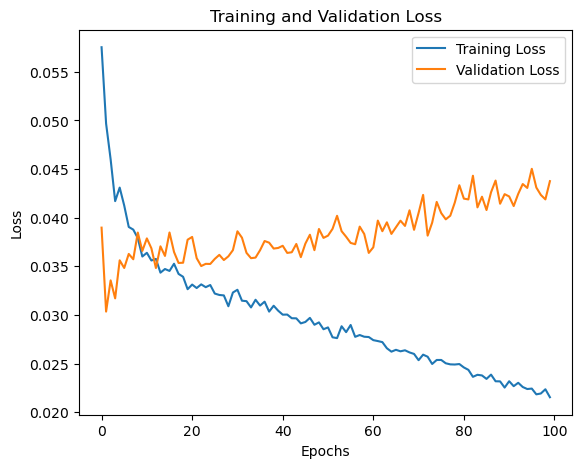

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 定义卷积层和池化层，用于提取特征
shared_layer = layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.001))(main_input)
shared_layer = layers.BatchNormalization()(shared_layer)
shared_layer = layers.MaxPooling1D(pool_size=2)(shared_layer)
shared_layer = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(shared_layer)
shared_layer = layers.BatchNormalization()(shared_layer)
shared_layer = layers.MaxPooling1D(pool_size=2)(shared_layer)
shared_layer = layers.Flatten()(shared_layer)

# 合并主要输入的特征表示和辅助输入
combined_input = layers.Concatenate(axis=-1)([shared_layer, aux_input])

# 定义隐藏层来处理合并后的表示
hidden_layer = layers.Dense(units=64, activation='relu')(combined_input)
hidden_layer = layers.BatchNormalization()(hidden_layer)
hidden_layer = layers.Dropout(0.5)(hidden_layer)
hidden_layer = layers.Dense(units=32, activation='relu')(hidden_layer)
hidden_layer = layers.BatchNormalization()(hidden_layer)

# 最终输出：cyber sickness 程度预测
cyber_sickness = layers.Dense(units=1, activation='sigmoid', name="cyber_sickness")(hidden_layer)

# 构建模型
model = Model(inputs=[main_input, aux_input], outputs=cyber_sickness)

# 编译模型
model.compile(
    loss=tf.keras.losses.Huber(),  # 使用 Huber Loss
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mean_squared_error']
)

# 打印模型摘要
model.summary()

# 添加 Early Stopping 回调
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 使用合成后的数据训练模型并记录训练历史
history = model.fit([all_padded_msdv_inputs, all_aux_inputs], all_reward_outputs, 
                    epochs=100, batch_size=32, validation_split=0.3,
                    # callbacks=[early_stopping]
                   )

# 预测cyber sickness
predicted_sickness = model.predict([all_padded_msdv_inputs, all_aux_inputs])

# 打印预测结果
print(predicted_sickness)

# 计算MSE
mse = mean_squared_error(all_reward_outputs, predicted_sickness)
print(f"Mean Squared Error (MSE): {mse}")

# 绘制训练和验证损失曲线
plt.figure(figsize=(14, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.savefig('ANN/ANN1.png')

# 显示图像
plt.show()


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE features shape: (4680, 2)


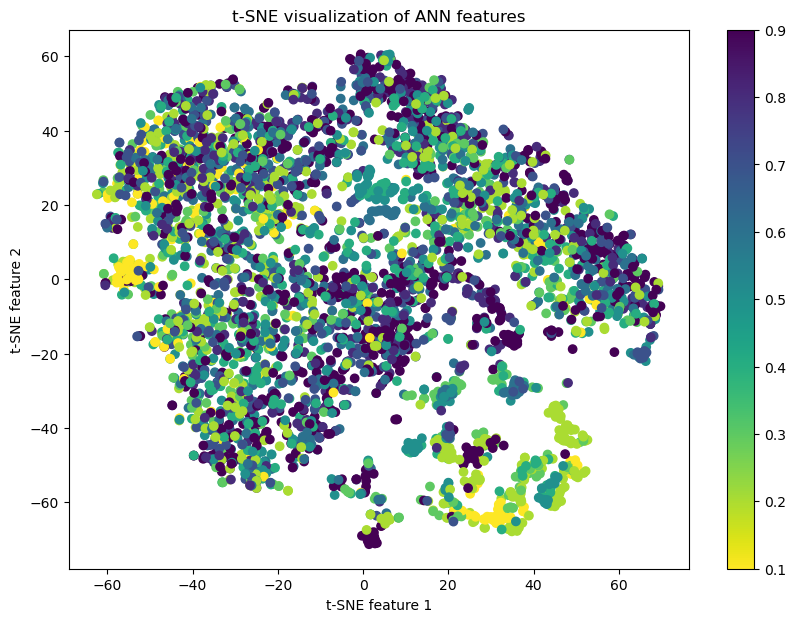

In [105]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# 构建一个新的模型，以便从已有模型中提取隐藏层的输出
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(model.layers[-2].name).output)

# 提取特征
features = feature_extractor.predict([all_padded_msdv_inputs, all_aux_inputs])

# 使用t-SNE降维到2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# 检查 t-SNE 输出的形状
print(f"t-SNE features shape: {tsne_features.shape}")

# 可视化 t-SNE 结果，使用反转的 'viridis' colormap
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=all_reward_outputs.flatten(), cmap='viridis_r')
plt.colorbar()
plt.title("t-SNE visualization of ANN features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")


plt.savefig('ANN/t-SNE1.1.png')
plt.show()
